<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src="https://www.mathworks.com/help/examples/stats/win64/ParellelBayeianOptimizationExample_01.png" 
/>

</figure>


<h1 style="width: 60%; color: Orange; font-size: 40pt;">
    <Strong>
        CEGM2003 project: Bayesian optimization for truss structures
    </Strong>
</h1>

<h2 id="Background"><B>
    Background<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     Structures that make optimal use of the material they are made of reduces the cost and environmental impact of their construction as the amount of material required. Optimization of structural design is a challenging task because of the high number of design parameters and the relatively expensive evaluation of the suitability of any given design. Standard optimization techniques in high-dimensional design space require a very large number of possible designs that need to be evaluated. In structural analysis, where evaluating the objective function and checking the constraints involves the solution of a structural mechanics problem, e.g. with finite elements, this quickly becomes very expensive, even if the model is relatively simple from structural point of view. Bayesian optimization is a machine-learning-based optimization technique that aims to reduce the number of evaluations of the objective function through data-driven exploration of the design space with a probabilistic surrogate.
</p>

<h2 id="Background"><B>
    Objective & Description<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>

<div style="width: 60%; border-top: 4px solid #34D058; border-left: 4px solid #34D058; background-color: #F6FFED; padding: 1em 1em 1em 1em; color: #24292E; margin: 10px 0 20px 0; box-sizing: border-box;">
    <div style="background-color: #34D058; color: white; padding: 0.2em 1em; margin: -1em -1em 0em -1em; font-size: 1.2em;"><strong>Project Objective</strong></div>
    <p><strong>The aim of this project is to find an optimal truss design,</strong><br>
    this will be achieved by finding an optimal set of nodal coordinates and cross-sectional properties. The primary objective is to minimize the total weight of the structure, while satisfying structural requirements. Optionally, additional objectives can be included, e.g. on the minimization of cutoff waste when reusing components from an existing inventory of elements.</p>
</div>

## <strong> X | Imports</strong>

In [245]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, ExpSineSquared, Matern, RBF, RationalQuadratic

from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tabulate import tabulate
import torch
import sys
import pandas as pd
import os

import io
from contextlib import redirect_stdout

sys.path.append('../pyJive/')
from utils import proputils as pu
from names import GlobNames as gn
import main

In [2]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## <strong> X | Classes & Dependencies</strong>

In [522]:
class TRUSS():
    def __init__(self, file_path, output_path, violation_penalty, scalers , bounds, imag_threshold = 3,freq_constraints= [20,40,60], mass_weight = 1, freq_weight = 1):
        # ------------------------------ DO NOT CHANGE  ------------------------------ #
        self.read_file_path = file_path
        self.write_file_path = output_path
        self.nodes = {} 
        self.connectivity = None

        self.scaler_y = scalers[0]
        self.scaler_a = scalers[1]
        self.bounds = bounds
        # --------------------------------- ATRIBUTES -------------------------------- #
        self.member_df = None
        self.y_coordinates =  None  
        self.x_coordinates =  None 
        self.cross_sections = None
        self.lengths = None
        self.max_mass = 0

        self.density = 7850 # kg/m^3 As per Garnachos
        self.violation_penalty = violation_penalty
        self.freq_constraints = freq_constraints
        self.mass_weight = mass_weight
        self.freq_weight = freq_weight

        self.temporary = None
    
    # -------------------------- Import & Writing Files -------------------------- #
    def read_geom_file(self):
        path = os.path.normpath(os.path.join(read_file_path,'bridge.geom'))
        with open(path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
                continue
            elif line.startswith('member:'):
                section = 'member'
                continue

            if section == 'node' and line:
                parts = line.split()
                node_number = int(parts[0])
                node_data = tuple(map(float, parts[1:]))
                nodes[node_number] = node_data
            elif section == 'member' and line:
                member_data = tuple(map(int, line.split()))
                members.append(member_data)

        self.nodes = nodes
        self.member_df = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])
        
        connectivity = self.member_df.to_numpy()
        self.connectivity = connectivity[:,:2]
        self.y_coordinates = np.array([value[1] for _ , value in self.nodes.items()])
        self.x_coordinates = np.array([value[0] for _ , value in self.nodes.items()])
    
    def get_write_geom_file(self,path_): 
        path = os.path.normpath(os.path.join(path_,'TRUSS.geom'))
        file = open(path)

        for i, (x, _) in self.nodes.items():
            self.nodes[i] = (x, self.y_coordinates[i])

        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.nodes.items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        connectivity = self.member_df.to_numpy()
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        output_file_path = os.path.normpath(os.path.join(self.read_file_path,'TRUSS.geom'))
        with open(output_file_path, 'w') as file:
            file.write(geom)
            
        return file.name
    
    def fit_scalers(self, initial_data):
        y_data = initial_data[:5].reshape(1, -1).T
        a_data = initial_data[5:].reshape(1, -1).T
        self.scaler_y.fit(y_data)
        self.scaler_a.fit(a_data)

    def scaler(self, mode, x_values, scaler_type):
        if scaler_type == 'y':
            scaler = self.scaler_y
        elif scaler_type == 'a':
            scaler = self.scaler_a
        
        x_values = x_values.reshape(1,-1).T
        if mode == 'scale':
            scaled_values = scaler.transform(x_values)
        elif mode == 'descale':
            scaled_values = scaler.inverse_transform(x_values)
        
        return scaled_values.flatten()
    # ---------------------------------------------------------------------------- #
    #                                TARGET FUNCTION                               #
    # ---------------------------------------------------------------------------- #
    def loss_function(self, x_list):
        """
        Calculate the loss for a given set of design parameters.
        Parameters:
        x_list (list): A list of design parameters.
        Returns:
        float: The calculated loss based on mass, frequency constraints, and imaginary penalties.
        """
        A_list, y_list = self.areas_coordinates_write_split(x_list)
        
        mass_truss = self.mass_truss(A_list, y_list)
        self.max_mass = max(self.max_mass, mass_truss)
        
        freq1, freq2, freq3 = self.eigenfrequencies(A_list)
        frequencies = [freq1, freq2, freq3]

        freq_penalty = 0
        for f, t in zip(frequencies, self.freq_constraints):
            diff = f - t
            penalty_factor = 1 if diff >= 0 else self.violation_penalty  # Steeper penalty if below the threshold
            freq_penalty += penalty_factor * (diff**2 / t**2)
            
        imag_parts = np.abs(np.sum(np.imag(frequencies)))
        excess_imag = max(0, imag_parts - self.imag_threshold)
        max_expected_exp_penalty = np.exp(1) - 1  # Adjust based on the maximum expected penalty
        
        # Calculate the normalized losses
        normalized_mass = mass_truss / self.max_mass
        normalized_freq_penalty = freq_penalty / len(self.freq_constraints)
        normalized_imag_penalty = (np.exp(excess_imag) - 1) / max_expected_exp_penalty
        
        # Compute total loss
        LOSS = (self.mass_weight * normalized_mass +
                self.freq_weight * normalized_freq_penalty +
                normalized_imag_penalty).real

        # Check for constraint violations
        constraint_violation = normalized_freq_penalty + normalized_imag_penalty
        
        # -------------------------- Optimisation monitoring ------------------------- #
        optmonitor_data = [
            ["Metric","Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation Level"],
            ["Value",LOSS, frequencies, mass_truss, normalized_mass, normalized_freq_penalty, constraint_violation]
        ]
        print(tabulate(optmonitor_data, headers="firstrow", tablefmt="grid"))
        # -------------------------- Error Handling ------------------------- #
        error_messages = []
        if mass_truss < 0:
            error_messages.append(f"Negative Mass Detected: {mass_truss}")
        if freq_penalty < 0:
            error_messages.append(f"Negative Frequency Penalty Detected: {freq_penalty}. Frequencies: {frequencies}")
        if error_messages:
            full_error_message = "Loss Function Errors Detected:\n" + "\n".join(error_messages)
            raise LossFunctionException(full_error_message) 
        return LOSS

    # ----------------------------- SUPPORT FUNCTIONS ---------------------------- #
    def eigenfrequencies(self,A_list):
        path = os.path.normpath(os.path.join(read_file_path,'bridge_frequency.pro'))
        
        props = pu.parse_file(path)
        props['model']['truss']['area'] = A_list
        props['init']['mesh']['file'] = self.get_write_geom_file(self.read_file_path)
        
        # Call the program and store output in globdat
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        
        return (globdat[gn.EIGENFREQS][0:3]/2/np.pi)

    def mass_truss(self,areas, y_list):
        x_coordinates = self.x_coordinates
        y_coordinates = self.y_coordinates
        # --------------------------- calculate the y coordinates -------------------------- #
        for i in range(1, 6):
            y_coordinates[2 * i] = y_list[i-1]
            y_coordinates[20 - 2*i] = y_list[i-1]
        self.y_coordinates = y_coordinates
        # --------------------------- calculate the lengths -------------------------- #
        coordinates = list(zip(x_coordinates, y_coordinates))
        lengths = np.zeros(self.member_df.iloc[:,2].sum()) # Number of Elements
        for i, (node1, node2) in enumerate(self.connectivity):
            x1, y1 = coordinates[node1]
            x2, y2 = coordinates[node2]
            lengths[i] =  np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        # --------------------------- calculate the areas -------------------------- #
        n_elements = self.member_df.iloc[:,2].sum()
        areas_i = np.zeros(n_elements)
        cross_section_number = self.member_df.iloc[:,-1] 
        
        for i,item in enumerate(cross_section_number):
            if i == 15: 
                areas_i[i] = 1e-4
            else:
                areas_i[i] = areas[item]
        self.cross_sections = areas[:15]
        self.lengths = areas_i
        # --------------------------- calculate the mass -------------------------- #
        volumes = lengths * areas_i
        total_volume = np.sum(volumes)
        mass = total_volume * self.density

        return mass
    
    def calculate_length(self,node1, node2, coordinates):
        x1, y1 = coordinates[node1]
        x2, y2 = coordinates[node2]
        length =  np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        return length
    # ----------------------------------- OTHER ---------------------------------- #
    def Initial_guess(self):
        y_bound = self.bounds[0]
        A_bound = self.bounds[1]
        y = np.random.uniform(y_bound[0], y_bound[1], 5)
        Areas = np.random.uniform(A_bound[0], A_bound[1], 15)
        x_list = np.append(y, Areas)
        return x_list 
    
    def areas_coordinates_write_split(self, x_list):        
        '''
        Splits the input vector into the areas and the y coordinates and updates attribute y_coordinates
        '''
        y_coordinates = self.y_coordinates
        areas = x_list[5:]
        y_coords = x_list[:5]
        for i in range(1, 6):
            y_coordinates[2 * i] = y_coords[i-1]
            y_coordinates[20 - 2 * i] = y_coords[i-1]
        self.y_coordinates = y_coordinates # Update
        
        return areas, y_coords

In [511]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size, bounds):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.bounds = bounds
        self.boundsmm = [(0,1),(0,1)] # Bounds consistent with Minmax scaling 
        self.x_bounds = [self.boundsmm[0]] * 5 + [self.boundsmm[1]] * 15 
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        self.uncertainty = []
        self.y_loss = []

        self.temporary = None
        
        matern_length_scale_bounds = (1e-3, 1e10)
        initial_length_scale = np.ones(20)
        kernel = ConstantKernel(1.0) * Matern(length_scale=initial_length_scale, length_scale_bounds=matern_length_scale_bounds, nu=0.5)

        self.gauss_pr =  GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def _get_expected_improvement(self, x_new):
        '''
        Calculates the expected improvement at a given point x_new
        '''
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array(x_new).reshape(1, -1), return_std=True)
        if sigma_y_new[0] == 0.0:
            return 0.0
        
        min_mean_y = self.y_min
        z = (min_mean_y - mean_y_new) / sigma_y_new        
        exp_imp = (min_mean_y - mean_y_new) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        return exp_imp
  
    def _get_next_probable_point(self):
        '''
        We only standardise the data after the minimisation so the LOSS FUNCTION operates with standard scales
        ### FIX , Before We were only returning if better this does not allow the gaussian process to understand the data as well
        '''
        x_optimal = None
        x_next_sc = None
        max_acq_value = float('inf')

        for _ in range(self.batch_size):
            x_start = self.next_guess()  # Random starting point for exploration 
            x_start_sc = self.scaler(x_start, 'scale')       

            res = minimize(fun=self._acquisition_function, x0=x_start_sc, bounds = self.x_bounds, method='L-BFGS-B')
            # --------------------------------- Normalise -------------------------------- #
            if res.fun < max_acq_value:
                max_acq_value = res.fun
                x_next_sc = res.x
                x_optimal = self.scaler(x_next_sc, 'descale')

        return x_optimal, x_next_sc, -max_acq_value  #Note: Negative min neg acq function
    
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array([y]), axis = 0)
  
    def optimize(self):
        '''
        Optimize the target function using the Gaussian Process Regressor.

        Returns:
        - optimal_x: The optimal input values that minimize the target function.
        - y_min: The minimum value of the target function.
        '''
        # Initialize the Gaussian Process Regressor with the best guess
        y_min_ind = np.argmin(self.y_init)
        y_min = self.y_min = self.y_init[y_min_ind] 
        optimal_x = self.x_init[y_min_ind]
        optimal_ei = None

        if isinstance(self.y_init, list):
            self.y_init = np.array(self.y_init)
        
        for i in range(self.n_iter):
            print(f'Iteration: {i} Best loss = {y_min:.2f}\n')
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next ,x_next_sc, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array(x_next)) ## Call loss Function
            self._extend_prior_with_posterior_data(x_next_sc,y_next)
            if ((y_next < y_min) & (y_next > 0)):
                y_min = self.y_min = y_next
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(norm(prev_x - x_next))
                prev_x = x_next

            self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"x": [optimal_x],"y": [y_min], "ei": [optimal_ei]})), ignore_index=True) 
        return optimal_x, y_min

    def next_guess(self):
        y_bound = self.bounds[0]
        A_bound = self.bounds[1]
        y = np.random.uniform(y_bound[0], y_bound[1], 5)
        Areas = np.random.uniform(A_bound[0], A_bound[1], 15)
        x_list = np.append(y, Areas)
        return x_list
    
    def scaler(self, x, mode):
        y_coords = x[:5]
        y_coords_sc = SC_wrapper(mode, y_coords, 'y')
        areas = x[5:]
        areas_sc = SC_wrapper(mode, areas, 'a')
        x_out = np.concatenate([y_coords_sc, areas_sc])
        return x_out 

In [381]:
# ------------------------------ OTHER FUNCTIONS ----------------------------- #
## WRAPPER FUNCTIONS TO CALL OBJECT AND OPTIMISATION METHODS
def LF_wrapper(x):
    return TRUSS1.loss_function(x)       

def SC_wrapper(mode,x,scaler):
    return TRUSS1.scaler(mode,x, scaler)

## CATCH OPTIMISATION EXCEPTIONS
class LossFunctionException(Exception):
    pass

## VISUALISATION & RESULTS
def final_results(x_list, Area_lower=4e-3):
    '''FIX THIS'''
    A_list = x_list[5:]
    A_list = np.append([Area_lower], A_list)
    y_list = x_list[0:5]

    if constraint(A_list, y_list) != 0:
        print(f'The constraints for the natural frequencies are not met')
    else:
        print(f'The constraints of the natural frequencies are met')

    mass = mass_TRUSS(A_list, y_list)
    eigenfrequencies = eigenfrequencies(A_list, y_list)

    return mass, eigenfrequencies

def plot_truss(file_path, OBJECT, cross_sections):
    # Read the input file and store in props object
    path = os.path.normpath(os.path.join(file_path,'bridge_frequency_plot.pro'))
    
    props = pu.parse_file(path)
    props['model']['truss']['area'] = cross_sections
    props['init']['mesh']['file'] = OBJECT.get_write_geom_file(file_path)

    # Call the program and store output in globdat
    trap = io.StringIO()
    with redirect_stdout(trap):
        globdat = main.jive(props)

## <strong> 1 | Initialisation</strong>

In [513]:
# -------------------------------- Definitions ------------------------------- #
read_file_path = '../truss_bridge/data'
write_file_path =  '../truss_bridge/data/@TRUSS'
violation_factor = 10
freq_constraints = [20,40,60]
mass_weight = 1
freq_weight = 4
A_bound = (0.001, 0.01)
y_bound = (0.5, 2)
mm_scaler_y = MinMaxScaler()
mm_scaler_a = MinMaxScaler()

bounds = [y_bound, A_bound]
scalers = [mm_scaler_y,mm_scaler_a]

TRUSS1 = TRUSS(read_file_path,
                write_file_path,
                violation_factor,
                scalers,
                bounds,
                imag_threshold= imag_threshold,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSS1.read_geom_file()
# -------------------------------- initiation -------------------------------- #
n_samples = 25 #Large Number to fit the scaler adequately
x_list = []
y_list = []
x_list_sc = []

for _ in range(n_samples):
    x_values = TRUSS1.Initial_guess()
    x_list.append(x_values)
 
trap = io.StringIO()
with redirect_stdout(trap):
    for x in x_list:
        LOSS = TRUSS1.loss_function(x)
        y_list.append(LOSS)

# ---------------------- scaling and fitting the scalers --------------------- #
y_values = np.linspace(y_bound[0], y_bound[1], 5) # Fit scalers according to bounds
a_values = np.linspace(A_bound[0], A_bound[1], 15)
x_values = np.concatenate([y_values, a_values])
x_values_reshaped = x_values
TRUSS1.fit_scalers(x_values_reshaped)

for item in x_list:
    y_coords = item[:5]
    y_coords_sc = SC_wrapper('scale', y_coords, 'y')
    areas = item[5:]
    areas_sc = SC_wrapper('scale', areas, 'a')
    x_out = np.concatenate([y_coords_sc, areas_sc])
    x_list_sc.append(x_out)

## <strong> 2 | Optimisation </strong>

In [524]:
TRUSS1_bopt.x_init[-1]

array([0.20893461, 0.87118023, 0.83954851, 1.        , 0.27854562,
       0.20628025, 0.03275041, 0.87583309, 0.13027752, 0.48919393,
       0.        , 0.78618509, 0.91264633, 0.52576173, 0.51823454,
       0.3605838 , 0.05069595, 0.45731783, 0.42678192, 0.06867201])

In [520]:
TRUSS1_bopt = BayesianOptimizer(target_func=LF_wrapper, x_init=x_list_sc, y_init=y_list, n_iter=20, batch_size=100, bounds=bounds)
optimal_x, y_max = TRUSS1_bopt.optimize()

Iteration: 0 Best loss = 1.94

+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==============================+
| Value    |      2.54919 | [20.309904254760276, 68.39610017551675, 79.34096261279623] |         2577.39 |               0.869187 |            0.202704 |                     0.202704 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
Iteration: 1 Best loss = 1.94

+----------+-

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 10 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.

+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==============================+
| Value    |      4.31954 | [10.747502433480628, 34.7725024791416, 53.81590166767706] |         1625.81 |               0.548279 |            0.805747 |                     0.805747 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
Iteration: 4 Best loss = 1.14



c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

+----------+--------------+---------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                     |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation Level |
+==========+==============+=========================================================+=================+========================+=====================+==============================+
| Value    |      5.52591 | [8.551322005249302, 40.014878329923, 53.54787730159803] |         1486.58 |               0.501326 |             1.13081 |                      1.13081 |
+----------+--------------+---------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
Iteration: 5 Best loss = 1.14



c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==============================+
| Value    |      2.47736 | [13.756114672532112, 51.068505050247154, 57.07695674231577] |         1548.01 |               0.522042 |            0.358319 |                     0.358319 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
Iteration: 6 Best loss = 1.14

+----------+--------------+------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==============================+
| Value    |      1.97273 | [16.17369154348137, 43.174177225556804, 53.69271747710364] |         1970.39 |               0.664485 |            0.160939 |                     0.160939 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
Iteration: 10 Best loss = 1.14

+----------+--------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 12 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.

+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==============================+
| Value    |      2.20499 | [15.419076196667314, 42.412715322171714, 52.00334586022921] |         1873.77 |               0.631901 |            0.235296 |                     0.235296 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
Iteration: 13 Best loss = 1.14

+----------+--------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 16 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings

+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==============================+
| Value    |       8.4436 | [5.6964863723403205, 35.20916888722359, 58.255417376160096] |          2107.4 |               0.710688 |             1.75556 |                      1.75556 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------+
Iteration: 16 Best loss = 1.14

+----------+--------------+-----------

## <strong> 3 | Visulisation & Results </strong>

In [196]:
TRUSS1_bopt.best_samples_.iloc[0]

x     [-0.7601142665754779, 2.439898242265184, 0.323...
y                               (1.3614033294242944+0j)
ei                                              1.51731
Name: 0, dtype: object

## <strong> XX | Demo 0 </strong>

In [238]:
TRUSS1_bopt = BayesianOptimizer(target_func= LF_wrapper, x_init= x_list, y_init= y_list, n_iter= 100, batch_size= 50, bounds= bounds)
optimal_x, y_max = TRUSS1_bopt.optimize()

Iteration: 0 Best loss = 0.80



c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 13 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      16.7334 | [6.767225014673432, 15.291208275591426, 23.967045625312604] |         11349.7 |                      1 |             3.93334 |                        0 |                      3.93334 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.707662 | [17.308558980002683, 46.295120831849786, 53.92495510103823] |         3365.04 |               0.296486 |            0.102794 |                        0 |                     0.102794 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |      13.7842 | [5.051882271614813, 18.40554884605641, 35.66214247797545] |         2907.83 |               0.256203 |             3.38201 |                        0 |                      3.38201 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |      9.23005 | [6.404394256392112, 24.04689429307897, 48.67411986826752] |         5365.66 |               0.472757 |             2.18932 |                        0 |                      2.18932 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.75505 | [13.553764928755278, 37.106520421874784, 52.883386608673014] |         1277.71 |               0.112576 |             0.41062 |                        0 |                      0.41062 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 12 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      9.07875 | [3.8776085508389353, 55.075658542394564, 68.05751614609541] |         2280.38 |                0.20092 |             2.21946 |                        0 |                      2.21946 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 16 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      5.03186 | [11.161734605107469, 27.182462995316897, 44.26071610422961] |         1605.42 |                0.14145 |              1.2226 |                        0 |                       1.2226 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 10 of parameter k2__length_scale is close to the specified upper bound 10000000000.0.

+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      17.1336 | [3.929346466898654, 9.784495501559313, 59.508713472680945] |         10392.7 |               0.915676 |             4.05447 |                        0 |                      4.05447 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |      4.49016 | [8.598462917208284, 42.99152547842351, 56.06982960137002] |         1047.86 |              0.0923247 |             1.09946 |                        0 |                      1.09946 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.574311 | [22.432522292782842, 57.37741257907098, 77.53636603486015] |          2145.6 |               0.189044 |           0.0963168 |                        0 |                    0.0963168 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                      |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.433361 | [20.90898613393924, 56.7163641174171, 74.98358784108673] |         1568.35 |               0.114592 |           0.0796923 |                        0 |                    0.0796923 |
+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+---------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 19 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.677519 | [15.693232809992326, 40.08351178870988, 58.835710924925955] |         937.612 |              0.0542176 |            0.155825 |                        0 |                     0.155825 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 14 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      19.5633 | [3.7527774851238855, 15.299035686257737, 21.70641547580905] |         4300.21 |                0.24866 |             4.82867 |                        0 |                      4.82867 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      16.5769 | [3.4039160312735404, 17.529557815029207, 33.52690148739543] |         10247.2 |               0.592544 |             3.99608 |                        0 |                      3.99608 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 14 of parameter k2__length_scale is close to the specified upper bound 10000000000.0.

+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      8.95354 | [7.417768323462324, 28.63401506134253, 35.340668189946854] |         6013.85 |               0.347752 |             2.15145 |                        0 |                      2.15145 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.720376 | [17.503106304937035, 59.9890053173414, 74.84327802766427] |         1694.63 |              0.0979922 |            0.155596 |                        0 |                     0.155596 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 16 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      10.6389 | [7.349020340515394, 19.958832879100175, 38.03139166862151] |         2930.06 |               0.169431 |             2.61736 |                        0 |                      2.61736 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.74196 | [13.580192036579716, 37.13786268274324, 51.690493834979364] |         763.727 |              0.0441626 |            0.424449 |                        0 |                     0.424449 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 18 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                      |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.271757 | [18.037648967711, 48.040236500238215, 58.71933201832229] |         1443.16 |              0.0834511 |           0.0470766 |                        0 |                    0.0470766 |
+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+---------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      5.32472 | [10.843703307868847, 29.27753075520878, 39.91210237868098] |         1340.19 |              0.0774968 |              1.3118 |                        0 |                       1.3118 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      22.4135 | [2.6884415708699145, 12.547076640240366, 20.689527161487096] |         7261.53 |               0.419899 |             5.49839 |                        0 |                      5.49839 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.491249 | [18.967162567278244, 58.8864034825624, 73.86273144639665] |         1509.16 |              0.0872674 |            0.100995 |                        0 |                     0.100995 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.459559 | [21.512783684033177, 50.89099707247598, 83.75453881397897] |         2491.89 |               0.144094 |           0.0788663 |                        0 |                    0.0788663 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. 

+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.91013 | [15.490032685514823, 37.120791346073354, 42.723566650762955] |         996.011 |              0.0575945 |            0.463135 |                        0 |                     0.463135 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.132462 | [20.609442623208743, 43.64512018972794, 61.235589326689016] |         2068.06 |               0.119586 |          0.00321898 |                        0 |                   0.00321898 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.48265 | [15.178673731135294, 34.171921744942885, 50.4313735526288] |         1481.21 |              0.0856514 |             0.34925 |                        0 |                      0.34925 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 14 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      22.9278 | [3.044276951509358, 12.313892095550173, 18.046398487183577] |         7574.68 |               0.438007 |             5.62245 |                        0 |                      5.62245 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                      |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.664945 | [20.44106585199701, 60.5124205852125, 84.70599173995397] |         1514.82 |              0.0875947 |            0.144338 |                        0 |                     0.144338 |
+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+---------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      2.14978 | [12.625868534767866, 54.33395420993257, 73.29462666508576] |         1738.16 |               0.100509 |            0.512319 |                        0 |                     0.512319 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      16.9395 | [5.716815677581404, 17.109606167932256, 21.39906144525267] |          4394.1 |                0.25409 |             4.17134 |                        0 |                      4.17134 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 18 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.906553 | [15.234457852738178, 41.00028318583746, 62.38351403140815] |         2535.26 |               0.146602 |            0.189988 |                        0 |                     0.189988 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 18 of parameter k2__length_scale is close to the specified upper bound 10000000000.0

+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      13.4881 | [6.7055963929550515, 19.987039214735297, 26.754167459262444] |         2860.09 |               0.165385 |             3.33067 |                        0 |                      3.33067 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0.

+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      2.42518 | [12.529206529695445, 60.22483196807682, 78.46128700465528] |         1688.86 |              0.0976589 |            0.581881 |                        0 |                     0.581881 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 12 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.902378 | [18.508134174486624, 65.3196416778228, 83.22697428046735] |         1628.01 |              0.0941399 |            0.202059 |                        0 |                     0.202059 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 17 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.581003 | [20.122446104771395, 60.09833164855509, 74.16322657328425] |         2940.57 |               0.170039 |            0.102741 |                        0 |                     0.102741 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0

+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      3.18624 | [11.272049044635933, 44.912722272857714, 49.05583076597825] |         3169.53 |               0.183279 |             0.75074 |                        0 |                      0.75074 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 10 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0

+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.15617 | [22.88162725724555, 71.93588672296481, 83.05297274770325] |         1413.59 |               0.081741 |            0.268607 |                        0 |                     0.268607 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 17 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.09038 | [16.375778719684053, 34.183092822435675, 51.96015360935137] |         2268.47 |               0.131175 |            0.239802 |                        0 |                     0.239802 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 12 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.10185 | [14.664902198867425, 37.01751949802721, 65.43302724680414] |         1176.14 |              0.0680105 |            0.258459 |                        0 |                     0.258459 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 16 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |       21.154 | [3.0364678013859554, 12.066227979874897, 25.80198407757204] |           12589 |                0.72796 |              5.1065 |                        0 |                       5.1065 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.075282 | [19.484431004405877, 39.86150570746005, 58.95148532711061] |         1075.48 |                0.06219 |            0.003273 |                        0 |                     0.003273 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 17 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      15.3487 | [5.801550498762051, 16.533453345012827, 27.39922306393618] |         1790.42 |               0.103531 |              3.8113 |                        0 |                       3.8113 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |       0.1235 | [18.85979160339803, 39.262786727961625, 63.354098150386804] |         1235.94 |              0.0714683 |           0.0130079 |                        0 |                    0.0130079 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

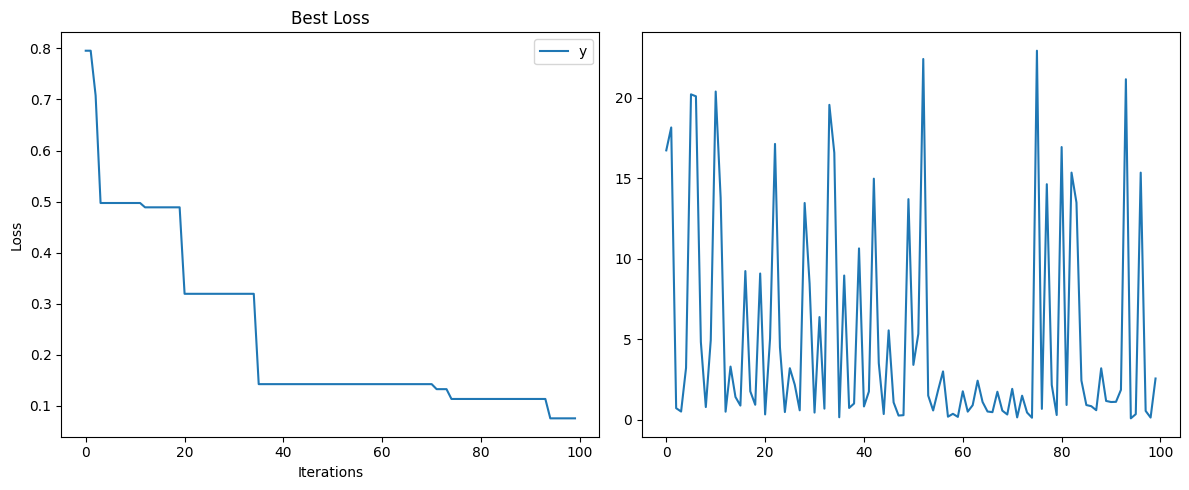

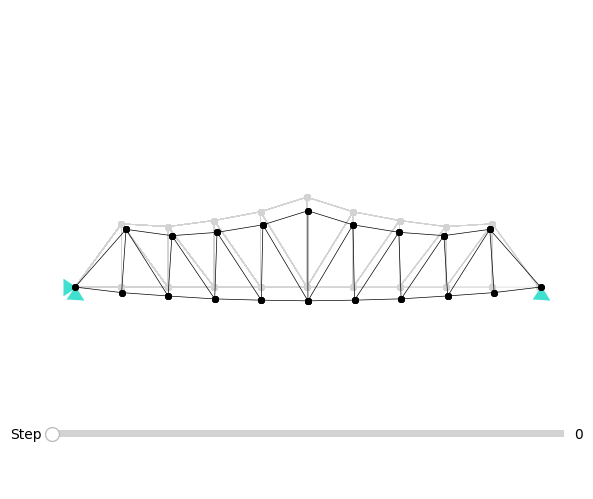

In [239]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
pd.DataFrame(TRUSS1_bopt.best_samples_['y']).plot(ax=plt.subplot(1, 2, 1), title='Best Loss', xlabel='Iterations', ylabel='Loss')
plt.subplot(1, 2, 2).plot(TRUSS1_bopt.y_loss)

plt.tight_layout()
plt.show()
plot_truss(write_file_path,TRUSS1, TRUSS1.cross_sections) ## FIX THIS